<a href="https://colab.research.google.com/github/cnddlf/Deep-Learning-Study/blob/main/ResNet18_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet 모델 정의 및 인스턴스 초기화


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os

class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        # 3x3 필터를 사용 (너비와 높이를 줄일 때는 stride 값 조절)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        # 3x3 필터를 사용 (패딩을 1만큼 주기 때문에 너비와 높이가 동일)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        self.shortcut = nn.Sequential() # identity인 경우
        if stride != 1: # stride가 1이 아니라면, Identity mapping이 아닌 경우
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # (핵심) skip connection
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # 64개의 3x3 필터(filter)를 사용
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


# ResNet18 함수 정의
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

# def ResNet34():
#     return ResNet(BasicBlock, [3, 4, 6, 3])

# def ResNet50():
#     return ResNet(BasicBlock, [3, 4, 6, 3])


In [ ]:
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),

])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

100%|██████████| 170498071/170498071 [00:01<00:00, 104670493.08it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
device = 'cuda'

net = ResNet18()
net = net.to(device)
net = torch.nn.DataParallel(net)
cudnn.benchmark = True

# learning_rate = 0.1
learning_rate = 0.0001
file_name = 'resnet18_cifar10.pt'

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.0002)


def train(epoch):
    print('\n[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    # train_loss_history = []
    # train_accuracy = []
    # train_epoch = [epoch]
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        # Forward pass
        benign_outputs = net(inputs)
        loss = criterion(benign_outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        epochs.append([epoch])

        train_loss += loss.item()
        train_loss_history.append(loss.item())
        _, predicted = benign_outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        train_accuracy.append(predicted.eq(targets).sum().item())

        if batch_idx % 100 == 0:
            print('\n batch:', str(batch_idx))
            print('train accuracy:', str(predicted.eq(targets).sum().item() / targets.size(0)))
            print('train loss:', loss.item())


    print('\nTotal benign train accuarcy:', 100. * correct / total)
    print('Total benign train loss:', train_loss)
    return train_loss_history, train_accuracy, epochs

def test(epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        epochs.append([epoch])

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()
        test_loss_history.append(criterion(outputs, targets).item())
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        test_accuracy.append(predicted.eq(targets).sum().item())

    print('\nTest accuarcy:', 100. * correct / total)
    print('Test average loss:', loss / total)

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')
    return test_loss_history, test_accuracy, epochs

# def adjust_learning_rate(optimizer, epoch):
#     lr = learning_rate
#     if epoch >= 100:
#         lr /= 10
#     if epoch >= 150:
#         lr /= 10
#     for param_group in optimizer.param_groups:
#         param_group['lr'] = lr

In [ ]:
train_loss_history = []
train_accuracy = []
test_loss_history = []
test_accuracy = []
epochs = []
# for epoch in range(0, 200):
for epoch in range(0, 21):
    # adjust_learning_rate(optimizer, epoch)
    train(epoch)
    test(epoch)


[ Train epoch: 0 ]

 batch: 0
train accuracy: 0.0703125
train loss: 2.4333715438842773

 batch: 100
train accuracy: 0.515625
train loss: 1.3454760313034058

 batch: 200
train accuracy: 0.5625
train loss: 1.261232852935791

 batch: 300
train accuracy: 0.5546875
train loss: 1.18525230884552

Total benign train accuarcy: 49.08
Total benign train loss: 544.0142393708229

[ Test epoch: 0 ]

Test accuarcy: 57.51
Test average loss: 0.009682848954200745
Model Saved!

[ Train epoch: 1 ]

 batch: 0
train accuracy: 0.5390625
train loss: 1.156012773513794

 batch: 100
train accuracy: 0.59375
train loss: 0.9884445667266846

 batch: 200
train accuracy: 0.65625
train loss: 0.9658880233764648

 batch: 300
train accuracy: 0.7109375
train loss: 0.7466064691543579

Total benign train accuarcy: 65.502
Total benign train loss: 380.4347608089447

[ Test epoch: 1 ]

Test accuarcy: 69.45
Test average loss: 0.006823776769638062
Model Saved!

[ Train epoch: 2 ]

 batch: 0
train accuracy: 0.734375
train loss: 0

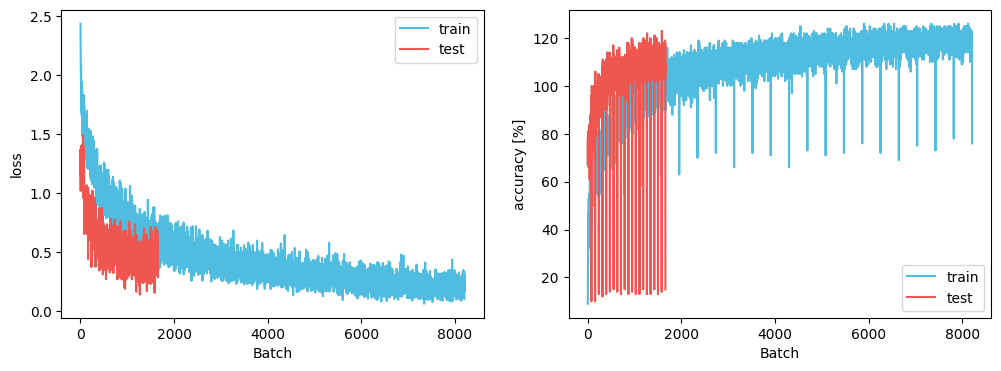

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, color='#50BCDF', label='train')
plt.plot(test_loss_history, color='#f05650', label='test')
# plt.xlabel('Epoch')
plt.xlabel('Batch')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, color='#50BCDF', label='train')
plt.plot(test_accuracy,  color='#f05650', label='test')
# plt.ylim(,)
# plt.xlabel('Epoch')
plt.xlabel('Batch')
plt.ylabel('accuracy [%]')
plt.legend()

plt.show()
